In [1]:
import pandas as pd
import numpy as np
import random
import json
import math
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import keras
import tensorflow_privacy.privacy.optimizers as optimizers
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy
import gc
from tensorflow.keras import backend as k

import warnings
warnings.filterwarnings('ignore')
#tf.compat.v1.disable_v2_behavior()


In [2]:
def set_random_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)

In [3]:
FILES_DIRECTORY = 'data/csv_rows/'
EPOCHS = 58
LEARNING_RATE = 1e-3
N = 1421664
NUMBER_OF_FEATURES = 5000
BATCH_SIZE = 16
DELTA = 1e-7
NOISE_MULTIPLIER = 0.38559


In [4]:
def print_msg_box(msg, indent=1, width=None, title=None):
    """Print message-box with optional title."""
    lines = msg.split('\n')
    space = " " * indent
    if not width:
        width = max(map(len, lines))
    box = f'╔{"═" * (width + indent * 2)}╗\n'  # upper_border
    if title:
        box += f'║{space}{title:<{width}}{space}║\n'  # title
        box += f'║{space}{"-" * len(title):<{width}}{space}║\n'  # underscore
    box += ''.join([f'║{space}{line:<{width}}{space}║\n' for line in lines])
    box += f'╚{"═" * (width + indent * 2)}╝'  # lower_border
    print(box)


# Create bow model

In [5]:
def shuffle_data(data):
    set_random_seeds(42)
    data = data.sample(frac=1).reset_index(drop=True)
    return data

In [6]:
f_stopwords = open('stopwords.json')
stopwords_list = json.load(f_stopwords)

In [7]:
def create_bow_model(train_data, test_data, metric: str, remove_stop_words: bool):
    #stop words removal
    stop_words = None
    if (remove_stop_words == True):
        stop_words = stopwords_list

    token_pattern = r"(?u)\b\w\w+\b"

    #create model with given metric
    bow = None
    if (metric == 'count'):
        bow = CountVectorizer(
            max_features=NUMBER_OF_FEATURES, stop_words=stop_words, token_pattern=token_pattern)
    elif (metric == 'tfidf'):
        bow = TfidfVectorizer(
            max_features=NUMBER_OF_FEATURES, stop_words=stop_words, token_pattern=token_pattern)
    elif (metric == 'binary'):
        bow = CountVectorizer(max_features=NUMBER_OF_FEATURES, stop_words=stop_words,
                              binary=True, token_pattern=token_pattern)
    else:
        raise ValueError("metric must be either %s or %s or %s!" %
                         ('<count>', '<tfidf>', '<binary>'))

    #create data partititions
    X_train = bow.fit_transform(train_data['content'])
    y_train = train_data['polarity']
    X_test = bow.transform(test_data['content'])
    y_test = test_data['polarity']

    return (X_train, y_train, X_test, y_test)

# Calculate privacy budget

In [8]:
compute_dp_sgd_privacy(N, BATCH_SIZE, NOISE_MULTIPLIER,
                       EPOCHS, DELTA)

DP-SGD with sampling rate = 0.00113% and noise_multiplier = 0.38559 iterated over 5153532 steps satisfies differential privacy with eps = 10 and delta = 1e-07.
The optimal RDP order is 3.0.


(10.048064406317497, 3.0)

# Train models

## Logistic Regression

In [9]:
def unison_shuffled_copies(a, b):
    assert a.shape[0] == len(b)
    shuffler = np.random.permutation(a.shape[0])
    return a[shuffler], b[shuffler]


In [10]:
def build_lr_model_baseline():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        1, activation='sigmoid', input_dim=NUMBER_OF_FEATURES))
    loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.NONE)
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
        loss=loss,
        metrics=['accuracy'])
    return model

In [11]:
def build_lr_model_DP():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(1, activation='sigmoid',
                    input_dim=NUMBER_OF_FEATURES))
    loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.losses.Reduction.NONE)
    model.compile(
        optimizer=optimizers.dp_optimizer_keras.DPKerasSGDOptimizer(
            l2_norm_clip=1,
            noise_multiplier=NOISE_MULTIPLIER,
            num_microbatches=BATCH_SIZE,
            learning_rate=LEARNING_RATE),
        loss=loss,
        metrics=['accuracy'])
    return model


In [12]:
def plot_training_loss(history):
    #take average loss of each epoch
    history.history['loss'] = [(lambda x: np.mean(x))(x)
                               for x in history.history['loss']]
    history.history['val_loss'] = [(lambda x: np.mean(x))(x)
                                   for x in history.history['val_loss']]

    # summarize history for loss
    plt.plot(range(1, len(history.history['loss'])+1),
             history.history['loss'], label="train")
    plt.plot(range(1, len(history.history['val_loss'])+1),
             history.history['val_loss'], label="test")
    plt.title('model loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


In [13]:
def plot_training_acc(history):
    #take average loss of each epoch
    history.history['accuracy'] = [(lambda x: np.mean(x))(x)
                                   for x in history.history['accuracy']]
    history.history['val_accuracy'] = [(lambda x: np.mean(x))(x)
                                       for x in history.history['val_accuracy']]

    # summarize history for acc
    plt.plot(range(1, len(history.history['accuracy'])+1),
             history.history['accuracy'], label="train")
    plt.plot(range(1, len(history.history['val_accuracy'])+1),
             history.history['val_accuracy'], label="test")
    plt.title('model accuracy')
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()


In [14]:
def evaluate_model(model, test_X, test_y):
    yhat = model.predict(test_X)

    yhat[yhat < 0.5] = 0
    yhat[yhat >= 0.5] = 1

    acc = accuracy_score(test_y, yhat)
    print(classification_report(test_y, yhat))
    print('Accuracy: ' + str(acc))
    
    return acc

In [15]:
def save_history_to_file(history, file):
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(file)

In [16]:
def generate_batches_shuffled(X_train_bow, y_train_bow):
    set_random_seeds(42)
    while True:
        #shuffle before each epoch
        X_train_bow, y_train_bow = unison_shuffled_copies(
            X_train_bow, y_train_bow)
        for j in range(0, X_train_bow.shape[0], BATCH_SIZE):
            x_batch = X_train_bow[j: j+BATCH_SIZE, :].todense()
            y_batch = y_train_bow[j: j+BATCH_SIZE]
            yield (x_batch, y_batch)

        gc.collect()

In [17]:
def train(model, X_train, y_train, X_val, y_val, preprocessing_row, metric):
    set_random_seeds(42)

    print("\n")
    print_msg_box('Logistic Regression:', indent=10)
    
    #callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                     patience=3, min_lr=1e-6, verbose=1, min_delta=1e-5)
    #train
    history = model.fit_generator(generate_batches_shuffled(X_train, y_train), steps_per_epoch=math.ceil(len(y_train) / BATCH_SIZE), epochs=EPOCHS,
                                  use_multiprocessing=False, shuffle=True, validation_data=(X_val.todense(), y_val), callbacks=[reduce_lr])
    print(model.summary())
    return history

In [18]:
def train_LR(X_train, y_train, X_test, y_test, X_val, y_val, metric, preprocessing_row):

    lr_model = build_lr_model_DP()
    history = train(lr_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, preprocessing_row=preprocessing_row, metric=metric)
    
    save_history_to_file(
        history, "models/histories/history_dp-eps=10.csv")
    
    #plots
    plot_training_loss(history)
    plot_training_acc(history)

    return evaluate_model(lr_model, X_test.todense(), y_test)

# Main function

In [19]:
def sentiment_analysis(remove_stop_words: bool, metric: str, preprocessing_row: int):

    msg = "Metric: %s\n" \
            "Preprocessing row: %d\n" \
            "Removing stop words: %s" % (metric, preprocessing_row, remove_stop_words)

    print_msg_box(msg=msg, indent=30, title='Sentiment Analysis:')

    #load train data
    print("\nLoad train data from %strain_row_%d.csv" %
          (FILES_DIRECTORY, preprocessing_row))
    train_data = pd.read_csv("%strain_row_%d.csv" % (FILES_DIRECTORY, preprocessing_row))
    train_data['content'] = train_data['content'].values.astype('str')
    
    #shuffle train data
    train_data = shuffle_data(train_data)

    #load test data
    print("Load test data from %stest_row_%d.csv\n" % (FILES_DIRECTORY, preprocessing_row))
    test_data = pd.read_csv("%stest_row_%d.csv" % (FILES_DIRECTORY, preprocessing_row))
    
    #create bow model
    X_train, y_train, X_test, y_test = create_bow_model(
        train_data=train_data, test_data=test_data, metric=metric, remove_stop_words=remove_stop_words)
        
    #reshape label vectors
    y_train[y_train == 4] = 1
    y_train = y_train.values.reshape(-1, 1)
    y_test[y_test == 4] = 1
    y_test = y_test.values.reshape(-1, 1)

    #split into train and validation data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=42)

    #leave out 6 samples because length has to be divisible by BATCH_SIZE (limitation by tensorflow privacy)
    leave_out_samples_X = X_train[-6:]
    leave_out_samples_y = y_train[-6:]
    X_train = X_train[:-6]
    y_train = y_train[:-6]
    
    #train LR Model
    acc_lr = train_LR(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                      X_val=X_val, y_val=y_val, metric=metric, preprocessing_row=preprocessing_row)

# Execution

╔═════════════════════════════════════════════════════════════════════════════════════╗
║                              Sentiment Analysis:                                    ║
║                              -------------------                                    ║
║                              Metric: count                                          ║
║                              Preprocessing row: 3                                   ║
║                              Removing stop words: True                              ║
╚═════════════════════════════════════════════════════════════════════════════════════╝

Load train data from data/csv_rows/train_row_3.csv
Load test data from data/csv_rows/test_row_3.csv



╔════════════════════════════════════════╗
║          Logistic Regression:          ║
╚════════════════════════════════════════╝
Epoch 1/58
88854/88854 [==============================] - 175s 2ms/step - loss: 0.6557 - accuracy: 0.6067 - val_loss: 0.6400 - val_accuracy: 0.6173 - l

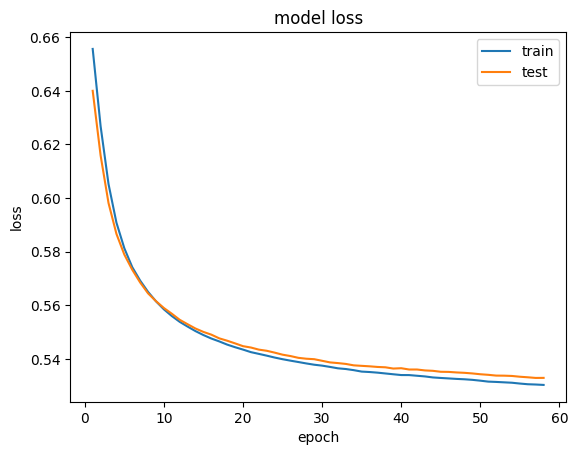

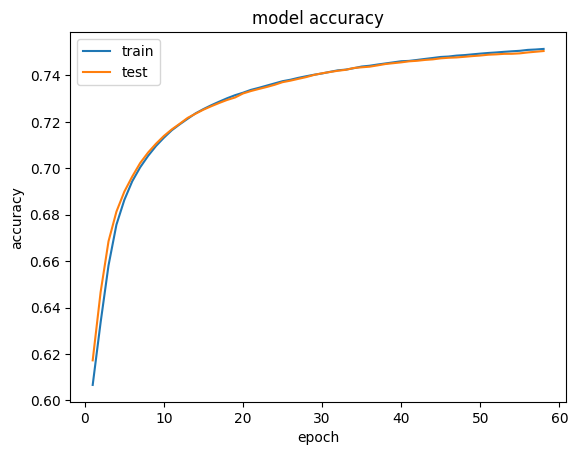

12/12 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       177
           1       0.77      0.82      0.79       182

    accuracy                           0.78       359
   macro avg       0.78      0.78      0.78       359
weighted avg       0.78      0.78      0.78       359

Accuracy: 0.7827298050139275


In [20]:
sentiment_analysis(True, metric= "count", preprocessing_row=3)